In [1]:
!pip install fastai
!pip install timm
import fastai
import timm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

timm is a package developed by Ross Wightman  that contains pretrained models ,1032 in total

In [2]:
from fastai.vision.all import *
url = '/content/drive/MyDrive/brain-tumor-dataset'
path =  Path(url)
path.ls()

(#6) [Path('/content/drive/MyDrive/brain-tumor-dataset/no'),Path('/content/drive/MyDrive/brain-tumor-dataset/yes'),Path('/content/drive/MyDrive/brain-tumor-dataset/models'),Path('/content/drive/MyDrive/brain-tumor-dataset/.ipynb_checkpoints'),Path('/content/drive/MyDrive/brain-tumor-dataset/tumor-resnet34.pkl'),Path('/content/drive/MyDrive/brain-tumor-dataset/convnext_tiny_in22k.pkl')]

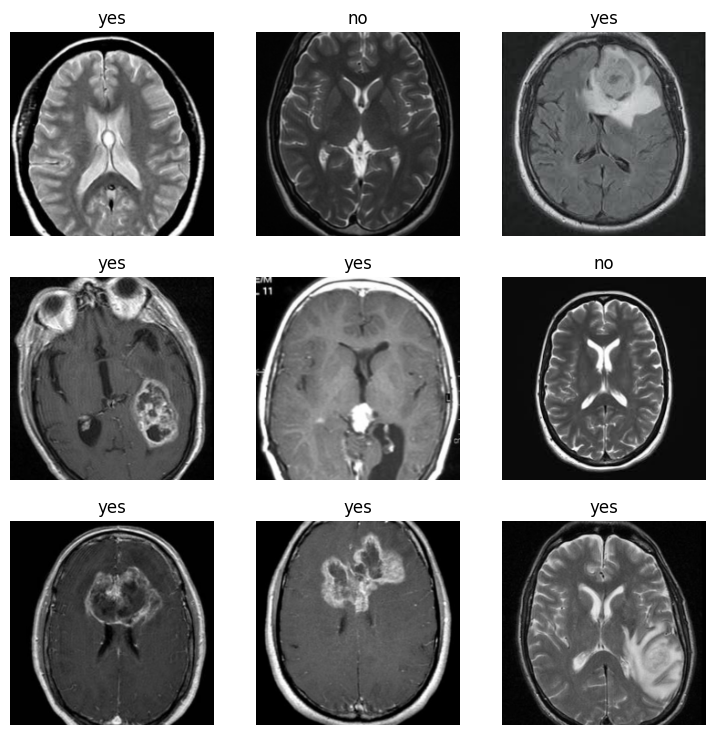

In [3]:
dls =  ImageDataLoaders.from_folder(path,valid_pct=0.2,seed = 42,item_tfms=Resize(224))
dls.show_batch()

The ImageDataLoaders.from_folder takes as first argument the Windows path of the directory where 
the data exists,as second argument the percentage of the whole dataset that we want to be validation 
set and for having reproducability we set the random seed equal to a number. And we also apply 
transformations to every image so that they have the same dimensions,in this case 224 pixels.

Batch is a small set of data that is used to train the model. Passing all the dataseet at once is 
very impractical and instead  we pass batch after batch to the model

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0006918309954926372)

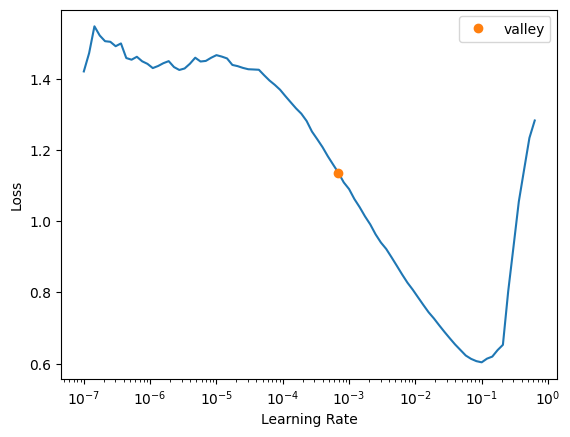

In [4]:
learn = vision_learner(dls,'convnext_tiny_in22k',metrics =  error_rate).to_fp16()
learn.lr_find()

In order to get a good model we have to choose  the learning rate appropriately. If we set it very low it 
can take many epochs for the model to get trained risking to let the model memorize the data(overfit).

Choosing a high learning rate means risking to overshot the loss and having low accuracy(underfit).

So how do we choose the leearning rate?

There is an approach developed by researcher Leslie Smith called the learning rate finder that chooses a very 
small learning rate ,trains a mini-batch with it and computes the loss. After it doubles the learning rate ,
trains another mini-batch,computes the loss and if th loss became smaller it continues until the loss starts 
to become worse.

In [5]:
learn.fit_one_cycle(3,6e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.375574,1.019470,0.360000,00:07
1,1.044941,0.331376,0.140000,00:02
2,0.870448,0.272646,0.080000,00:02


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


When we defined the learn object we defined the architecture that we will be using and the data used to train the modeel.

fit_one_cycle function's first argument is the number of epochs which is the number of times the modeel will pass from each datapoint,and the seecond argument is the learning rate used in stochastic gradient descent ,the algorithm used to train the weights so that the loss is minimized

SuggestedLRs(valley=9.120108734350652e-05)

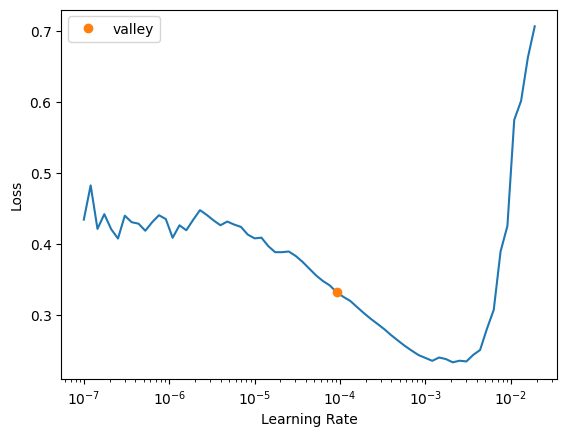

In [6]:
learn.unfreeze()
learn.lr_find()

In [7]:
learn.fit_one_cycle(3,lr_max=slice(5e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.494924,0.221893,0.100000,00:02
1,0.510012,0.154920,0.100000,00:02
2,0.424810,0.127885,0.060000,00:02


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [8]:
learn.export(fname = 'convnext_tiny_in22k_.pkl')

We trained a classifier with 94% accuracy which is a very good achievement.  But how does this work?

First we remove the last layer of the specified architecture ,in this case convnext_tiny_in22k which was trained on millions of images.

Second we add a new linear output layer with as many neurons as the classes of the output we want to predict and we train the weights in that layer with a high learning rate so that we minimize the loss fast.

After we unfreeze and train the whole model with a learning rate  equal to 5e-5 at the first layer and   gradually increasing it with the last layer having learning rate equal to 1e-3